In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

47

(32, 256, 256, 3)
[2 1 2 0 0 2 1 0 1 0 0 0 0 2 2 2 1 2 0 1 1 1 0 2 1 0 1 1 1 1 2 1]


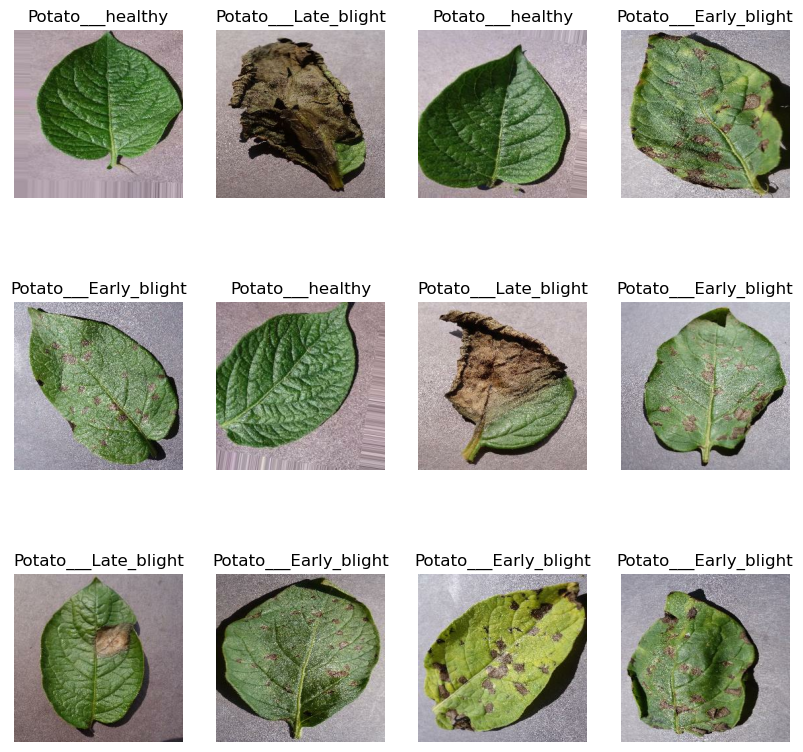

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

37 4 6


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
37/37 [==============================] - 49s 1s/step - loss: 1.0748 - accuracy: 0.4161 - val_loss: 1.1592 - val_accuracy: 0.3984
Epoch 2/20
37/37 [==============================] - 47s 1s/step - loss: 0.6662 - accuracy: 0.6856 - val_loss: 0.3992 - val_accuracy: 0.8281
Epoch 3/20
37/37 [==============================] - 47s 1s/step - loss: 0.4062 - accuracy: 0.8229 - val_loss: 0.3366 - val_accuracy: 0.8906
Epoch 4/20
37/37 [==============================] - 46s 1s/step - loss: 0.3814 - accuracy: 0.8466 - val_loss: 0.3248 - val_accuracy: 0.8672
Epoch 5/20
37/37 [==============================] - 47s 1s/step - loss: 0.3339 - accuracy: 0.8627 - val_loss: 0.2602 - val_accuracy: 0.8984
Epoch 6/20
37/37 [==============================] - 47s 1s/step - loss: 0.3128 - accuracy: 0.8686 - val_loss: 0.2735 - val_accuracy: 0.8906
Epoch 7/20
37/37 [==============================] - 46s 1s/step - loss: 0.2407 - accuracy: 0.9153 - val_loss: 0.2212 - val_accuracy: 0.9219
Epoch 8/20
37/37 [==

In [13]:
scores=model.evaluate(test_ds)
scores

6/6 [==============================] - 2s 223ms/step - loss: 0.1152 - accuracy: 0.9583


[0.11523979902267456, 0.9583333134651184]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[1.0747509002685547,
 0.6661778092384338,
 0.4062480032444,
 0.38136520981788635,
 0.3339095413684845,
 0.3128424882888794,
 0.2406618297100067,
 0.23646749556064606,
 0.28139421343803406,
 0.40115073323249817,
 0.2269354909658432,
 0.22631195187568665,
 0.18325306475162506,
 0.1997167021036148,
 0.20058777928352356,
 0.16406460106372833,
 0.13423410058021545,
 0.12947791814804077,
 0.127665176987648,
 0.14548245072364807]

In [16]:
history.history['accuracy']

[0.41610169410705566,
 0.6855932474136353,
 0.8228813409805298,
 0.8466101884841919,
 0.8627118468284607,
 0.8686440587043762,
 0.9152542352676392,
 0.9110169410705566,
 0.8966101408004761,
 0.8364406824111938,
 0.9084745645523071,
 0.9118643999099731,
 0.9355932474136353,
 0.9279661178588867,
 0.9203389883041382,
 0.9364407062530518,
 0.9533898234367371,
 0.949999988079071,
 0.9525423645973206,
 0.9389830231666565]

In [17]:
history.history['val_loss']

[1.1591682434082031,
 0.3992350101470947,
 0.3366336524486542,
 0.3248041868209839,
 0.2602158784866333,
 0.27351802587509155,
 0.22124603390693665,
 0.17482206225395203,
 0.6484273076057434,
 0.254161536693573,
 0.2070140838623047,
 0.24508655071258545,
 0.36724650859832764,
 0.2728143334388733,
 0.20002879202365875,
 0.1910671889781952,
 0.12387007474899292,
 0.14125363528728485,
 0.15837462246418,
 0.13897964358329773]

In [18]:
history.history['val_accuracy']

[0.3984375,
 0.828125,
 0.890625,
 0.8671875,
 0.8984375,
 0.890625,
 0.921875,
 0.9453125,
 0.828125,
 0.8828125,
 0.8984375,
 0.890625,
 0.859375,
 0.8671875,
 0.9140625,
 0.9140625,
 0.9453125,
 0.9453125,
 0.953125,
 0.9453125]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

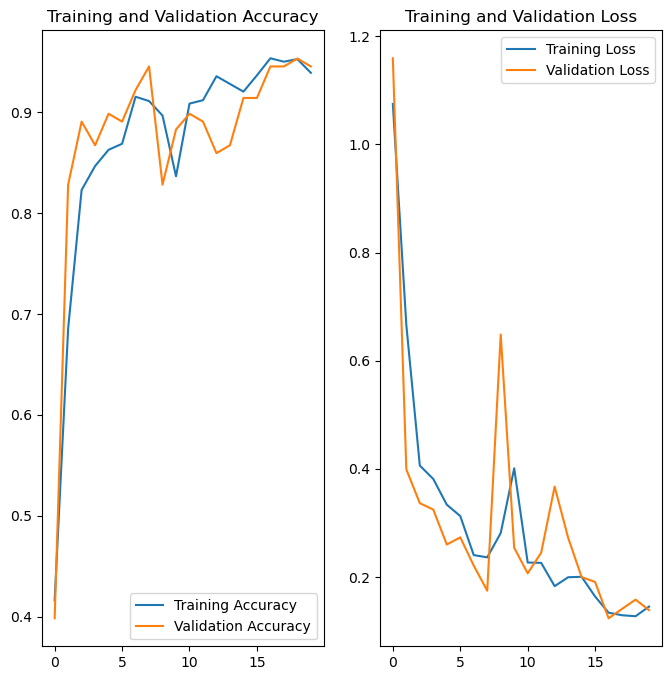

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [22]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(6):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 273ms/step


In [23]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


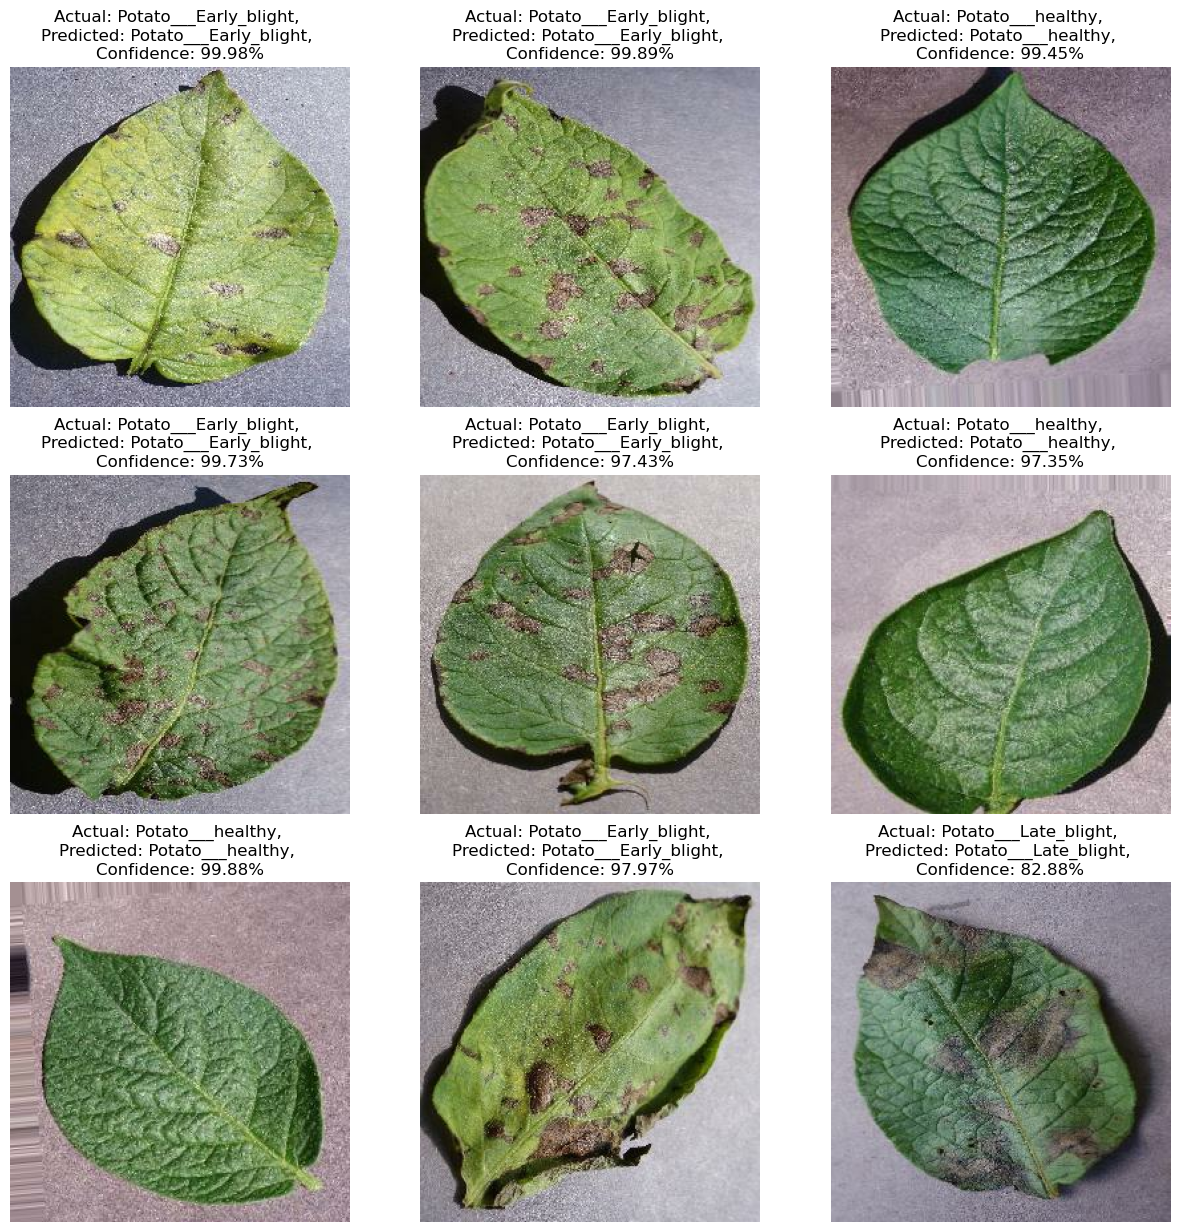

In [24]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [25]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        71
           1       0.98      0.88      0.93        60
           2       1.00      0.98      0.99        61

    accuracy                           0.96       192
   macro avg       0.96      0.96      0.96       192
weighted avg       0.96      0.96      0.96       192



In [26]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[71,  0,  0],
       [ 7, 53,  0],
       [ 0,  1, 60]])>

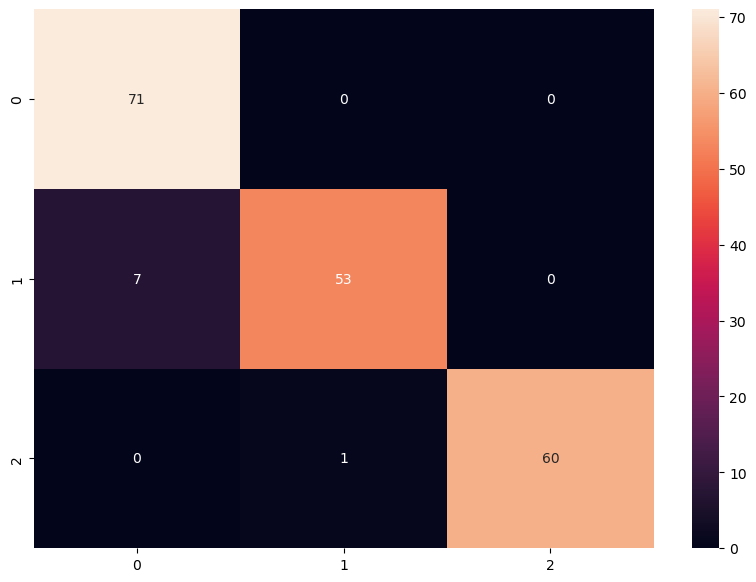

In [27]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [29]:
filename = "Model1-2-Epochs20.joblib"
joblib.dump(model, filename)

['Model1-2-Epochs20.joblib']